In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.fft import fft, ifft, fftfreq
from scipy.stats import linregress

In [48]:
def get_rainfall_season(rainfall_regular,label_season,offset_y):
    
    if label_season=='MAM':
        a = 3; b = 5; # a and b are the months to define the window of interest.
    elif label_season=='JJA':
        a = 6; b = 8; 
    elif label_season=='SON':
        a = 9; b = 11;
    elif label_season=='DJF':
        a = 12; b = 2; 
    
    # Define the time axis with annual time step
    yor = np.zeros_like(rainfall_regular)
    for ll in range(len(rainfall_regular)):
        yor[ll] = ll//12 + offset_y # year of the record.
    yor_u = np.unique(yor).astype(int)

    rainfall_season = np.zeros_like(yor_u)*np.nan

    for yy in range(len(yor_u)):
        if label_season=='DJF':
            if yy==0:
                ma = 0
                mb = 2
            else:
                ma = (yy-1)*12+(a-1)
                mb = yy*12+b          
        else:
            ma = yy*12+(a-1) # first month
            mb = yy*12+b # last month
        #print(rainfall_regular[ma:mb])
        rainfall_season[yy] = np.nanmean(rainfall_regular[ma:mb])
       
    return yor_u, rainfall_season

In [49]:
def get_nao_season(label_season):
    df_nao = pd.read_csv(path2data+'nao_3dp.dat',sep='\s+',na_values=-99.990)
    
    if label_season=='MAM':
        df_nao_season = df_nao.loc[:, df_nao.columns.isin(['mar', 'apr', 'may'])]
    if label_season=='JJA':
        df_nao_season = df_nao.loc[:, df_nao.columns.isin(['jun', 'jul', 'aug'])]
    if label_season=='SON':
        df_nao_season = df_nao.loc[:, df_nao.columns.isin(['sep', 'oct', 'nov'])]
    if label_season=='DJF':
        df_nao_season = df_nao.loc[:, df_nao.columns.isin(['jan', 'feb', 'dec'])]

    nao_season_months = df_nao_season.to_numpy().flatten()
    
    year_nao = df_nao.year.to_numpy()#.astype(str).astype('datetime64[Y]')
    nao_season = np.zeros_like(year_nao).astype('float')
    
    for yy in range(len(year_nao)):
        if label_season=='DJF':
            if yy==0:
                nao_season[yy] = np.nanmean(nao_season_months[0:2])
            else:
                nao_season[yy] = np.nanmean(nao_season_months[yy*3-1:yy*3+2])
        else:
            nao_season[yy] = np.nanmean(nao_season_months[yy*3:yy*3+3])

    return year_nao, nao_season

In [129]:
# v2 data
case_study = 'firenze'; title_str = 'Firenze'
#case_study = 'genova'; title_str = 'Genova'
#case_study = 'pisa'; title_str = 'Pisa'
#case_study = 'sarzana'; title_str = 'Sarzana'
#case_study = 'savona'; title_str = 'Savona'
#case_study = 'spezia'; title_str = 'Spezia'

path2data = "./data/"

In [130]:
# Read the filename of interest.
filename = case_study + '.csv'
df = pd.read_csv(path2data+'v2/'+filename)
df['date']= pd.to_datetime(df['date'])
time = df.date.to_numpy()

In [131]:
# Create an array of month from the beginning that is regular in time.
nyear = df.year.to_numpy()[-1]-df.year[0] # number of years.
nom = nyear*12+df.month.to_numpy()[-1] # number of months in the time series.
mfb_regular = np.arange(nom)

# Fill the regular rainfall series using nan where there are no data.
rainfall_regular = np.zeros_like(mfb_regular)*np.nan

ii = 0
for mm in mfb_regular: # Loop on the regular monthly time axis.
    im = (df.year[ii]-df.year[0])*12 + df.month[ii]-df.month[0] # Index month.
    if mm == im:
        rainfall_regular[mm] = df.rainfall[ii]
        ii += 1
        
# Get years and months to create a regular time axis.
years = time.astype('datetime64[Y]').astype(int) + 1970
months = time.astype('datetime64[M]').astype(int) % 12 + 1

offset_y = years[0]

yor = np.zeros_like(rainfall_regular)
moy = np.zeros_like(rainfall_regular)
time_regular = np.zeros_like(rainfall_regular).astype('datetime64[M]')

for ll in range(len(rainfall_regular)):
    yor[ll] = ll//12 + offset_y # year of the record.
    moy[ll] = ll%12 +1 # month of the year.
    time_regular[ll] = np.datetime64(str(yor[ll].astype(int))+'-'+str(moy[ll].astype(int)).zfill(2)+'-01')


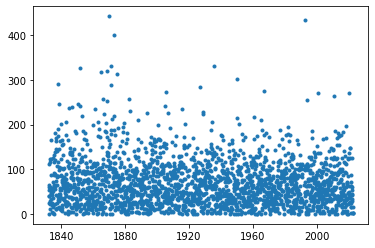

In [132]:
plt.plot(time,df.rainfall,'.')
#plt.ylim([0,600])

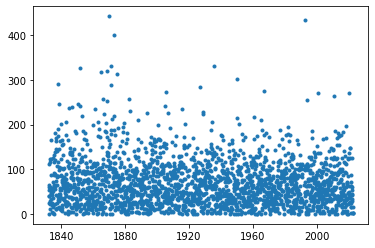

In [133]:
plt.plot(time_regular,rainfall_regular,'.')
#plt.ylim([0,600])

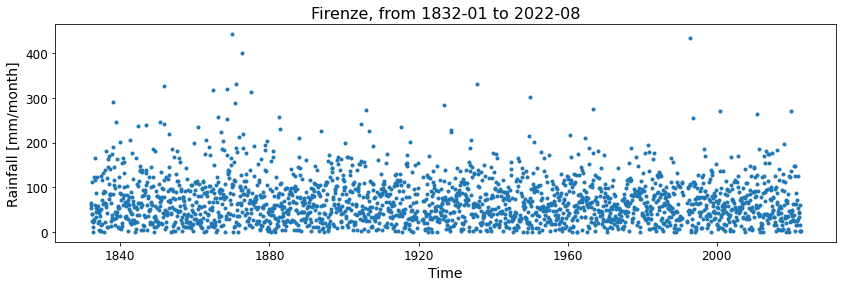

In [134]:
# Plot a figure to show the data for a given station.
plt.figure(figsize=(14,4))
plt.plot(time, df.rainfall,'.')
plt.ylabel('Rainfall [mm/month]',fontsize=14)
plt.xlabel('Time',fontsize=14)
plt.title(title_str+', from '+ np.datetime_as_string(time[0],unit='M')+
          ' to '+np.datetime_as_string(time[-1], unit='M'),fontsize=16)
plt.tick_params(axis='both', labelsize=12)

plt.savefig('./figures/'+case_study + '_monthly_timeseries.png',bbox_inches = 'tight')

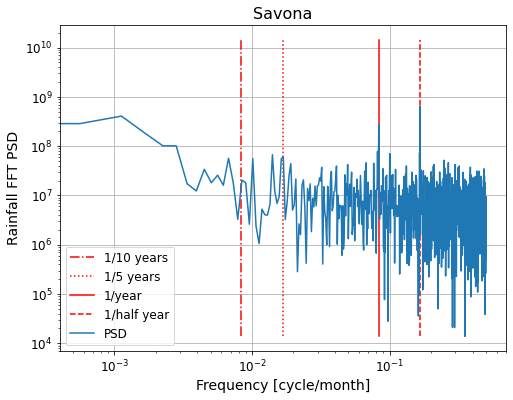

In [333]:
# Look at the FFT of the monthly data.

rainfall4fft = rainfall_regular
rainfall4fft[np.isnan(rainfall4fft)] = 0 # Replace nan with 0.

hat = fft(np.array(rainfall4fft))
freq = fftfreq(len(rainfall4fft)) # Cycles/month

plt.figure(figsize=(8,6))
psd = np.abs(hat)**2
a = np.min(psd)
b = np.max(psd)

plt.plot(1/120*np.array([1,1]),np.array([a,b]),'r-.')
plt.plot(1/60*np.array([1,1]),np.array([a,b]),'r:')
plt.plot(1/12*np.array([1,1]),np.array([a,b]),'r')
plt.plot(1/6*np.array([1,1]),np.array([a,b]),'r--')

N = len(psd)
plt.plot(freq[0:round(N/2)], psd[0:round(N/2)])

plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.ylabel('Rainfall FFT PSD',fontsize=14)
plt.xlabel('Frequency [cycle/month]',fontsize=14)
plt.legend(['1/10 years','1/5 years','1/year','1/half year','PSD'],fontsize=12)
plt.title(title_str,fontsize=16)
plt.tick_params(axis='both', labelsize=12)

plt.savefig('./figures/'+case_study + '_monthly_psd.png',bbox_inches = 'tight')

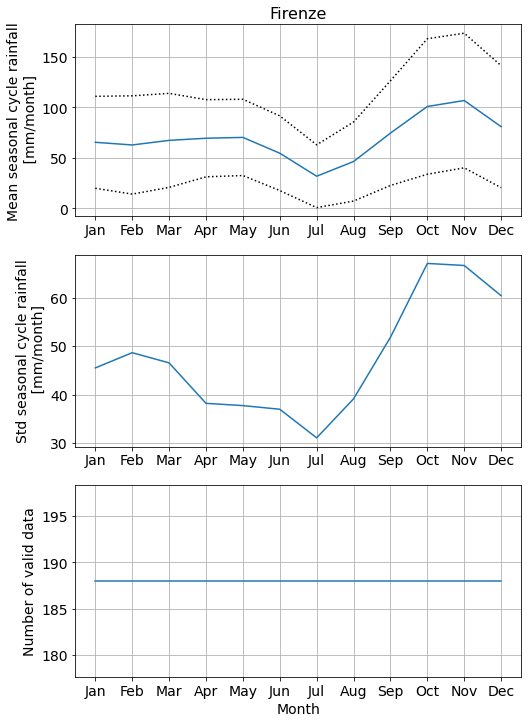

In [135]:
# Compute the seasonal cycle.

rainfall_year_rows = np.zeros((nyear,12))

for k in range(nyear):
    rainfall_year_rows[k,:] = rainfall_regular[12*k:12*(k+1)]
    
seasonal_cycle_mean = np.nanmean(rainfall_year_rows,axis=0)
seasonal_cycle_std = np.nanstd(rainfall_year_rows,axis=0)
seasonal_cycle_num = np.sum(np.double(~np.isnan(rainfall_year_rows)),axis=0)

fig, axs = plt.subplots(3,1,figsize=(8,12))#,sharex=True)

axs[0].plot(np.arange(12), seasonal_cycle_mean)
axs[0].plot(np.arange(12), seasonal_cycle_mean-seasonal_cycle_std,':k')
axs[0].plot(np.arange(12), seasonal_cycle_mean+seasonal_cycle_std,':k')
axs[0].set_ylabel('Mean seasonal cycle rainfall\n [mm/month]',fontsize=14)
axs[0].set_title(title_str,fontsize=16)
axs[0].set_xticks(np.arange(12))
axs[0].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
axs[0].tick_params(axis='both', labelsize=14)
axs[0].grid()

axs[1].plot(np.arange(12), seasonal_cycle_std)
axs[1].set_ylabel('Std seasonal cycle rainfall\n [mm/month]',fontsize=14)
axs[1].set_xticks(np.arange(12))
axs[1].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
axs[1].tick_params(axis='both', labelsize=14)
axs[1].grid()

axs[2].plot(np.arange(12), seasonal_cycle_num)
axs[2].set_ylabel('Number of valid data',fontsize=14)
axs[2].set_xlabel('Month',fontsize=14)
axs[2].set_xticks(np.arange(12))
axs[2].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
axs[2].tick_params(axis='both', labelsize=14)
axs[2].grid()

plt.savefig('./figures/'+case_study + '_seasonal_cycle.png',bbox_inches = 'tight')

In [136]:
# Separate the time series in seasons: get four separate time series with the seasonal averages
# (DJF, MAM, JJA, SON).

yor_u, rainfall_mam = get_rainfall_season(rainfall_regular,'MAM',offset_y)
yor_u, rainfall_jja = get_rainfall_season(rainfall_regular,'JJA',offset_y)
yor_u, rainfall_son = get_rainfall_season(rainfall_regular,'SON',offset_y)
yor_u, rainfall_djf = get_rainfall_season(rainfall_regular,'DJF',offset_y)

<ipython-input-48-f0ef4fb63114>:32: RuntimeWarning: Mean of empty slice
  rainfall_season[yy] = np.nanmean(rainfall_regular[ma:mb])


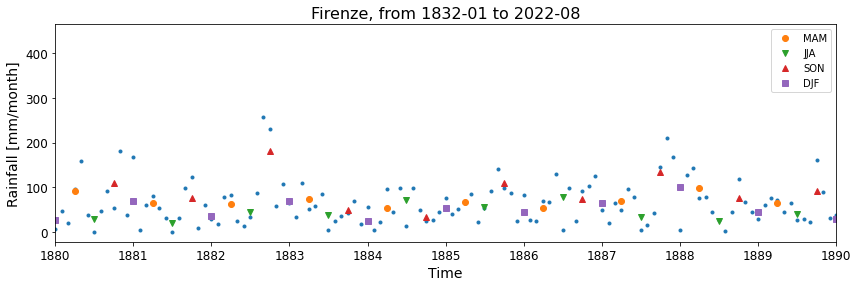

In [137]:
# Plot a figure to show the data for a given station. Add the seasonal rainfall time series.

time_year = yor_u.astype('str').astype('datetime64[Y]')

plt.figure(figsize=(14,4))
plt.plot(time, df.rainfall,'.')
plt.plot(time_year+np.timedelta64(3,'M'), rainfall_mam,'o',label='MAM')
plt.plot(time_year+np.timedelta64(6,'M'), rainfall_jja,'v',label='JJA')
plt.plot(time_year+np.timedelta64(9,'M'), rainfall_son,'^',label='SON')
plt.plot(time_year+np.timedelta64(0,'M'), rainfall_djf,'s',label='DJF')
plt.ylabel('Rainfall [mm/month]',fontsize=14)
plt.xlabel('Time',fontsize=14)
plt.title(title_str+', from '+ np.datetime_as_string(time[0],unit='M')+
          ' to '+np.datetime_as_string(time[-1], unit='M'),fontsize=16)
plt.tick_params(axis='both', labelsize=12)
plt.xlim([np.datetime64('1880-01-01'),np.datetime64('1890-01-01')])
plt.legend()

#plt.savefig('./figures/'+case_study + '_monthly_timeseries.png',bbox_inches = 'tight')

68.93847741032307
69.0881501643445


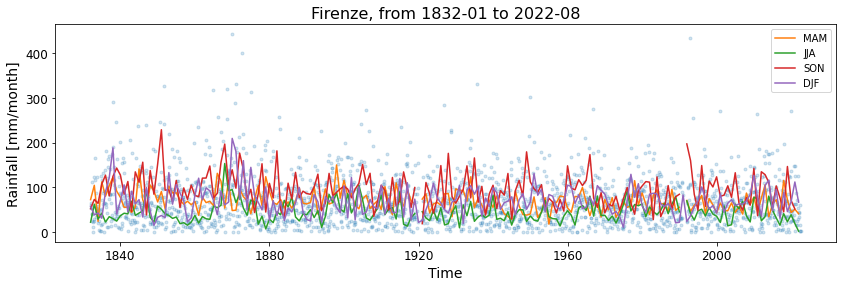

In [138]:
# Plot the seasonal rainfall time series. For some reasons, if you run the cell with the FFT the nans in 
# rainfall_regular are replaced with 0.

plt.figure(figsize=(14,4))
plt.plot(time, df.rainfall,'.',alpha=0.2)
plt.plot(time_year, rainfall_mam,'-',label='MAM')
plt.plot(time_year, rainfall_jja,'-',label='JJA')
plt.plot(time_year, rainfall_son,'-',label='SON')
plt.plot(time_year, rainfall_djf,'-',label='DJF')
plt.ylabel('Rainfall [mm/month]',fontsize=14)
plt.xlabel('Time',fontsize=14)
plt.title(title_str+', from '+ np.datetime_as_string(time[0],unit='M')+
          ' to '+np.datetime_as_string(time[-1], unit='M'),fontsize=16)
plt.tick_params(axis='both', labelsize=12)
#plt.xlim([np.datetime64('1880-01-01'),np.datetime64('1890-01-01')])
plt.legend()

plt.savefig('./figures/'+case_study + '_monthly_timeseries_and_seasonal.png',bbox_inches = 'tight')

print(np.nanmean(rainfall_mam))
print(np.mean(seasonal_cycle_mean[2:5]))

In [139]:
# Plot here the time series of the NAO.
df_nao = pd.read_csv(path2data+'nao_3dp.dat',sep='\s+',na_values=-99.990)
df_nao_monthly = df_nao.loc[:, ~df_nao.columns.isin(['year', 'annual'])]
df_nao_monthly

,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
0,NaN,NaN,NaN,NaN,NaN,NaN,-2.624,-0.143,NaN,NaN,NaN,NaN
1,NaN,NaN,2.988,-3.187,0.588,-0.862,-4.047,-0.190,-1.092,-2.003,-0.050,-0.734
2,-3.387,NaN,NaN,NaN,4.651,-0.835,0.580,2.903,0.669,-1.391,-0.757,-0.202
3,-0.162,0.250,-1.438,1.462,1.342,-3.945,-2.747,-0.075,0.193,NaN,-0.699,-0.006
4,-0.226,0.211,0.327,-0.276,0.131,0.410,-0.919,1.430,-0.947,1.981,1.059,-1.305
...,...,...,...,...,...,...,...,...,...,...,...,...
199,3.115,4.697,0.359,-0.706,-0.088,-1.523,-1.229,-1.362,0.487,-0.188,1.247,-0.780
200,-1.568,0.497,0.716,-3.309,-0.337,0.347,-1.587,-2.444,-0.158,0.495,-1.101,0.374
201,1.462,3.340,-0.335,-2.300,2.072,-0.337,0.599,-1.699,-3.731,0.859,2.372,-3.060
202,1.206,1.298,-0.595,-0.698,0.044,-2.899,-1.766,-1.754,-0.653,-1.229,-0.427,0.671


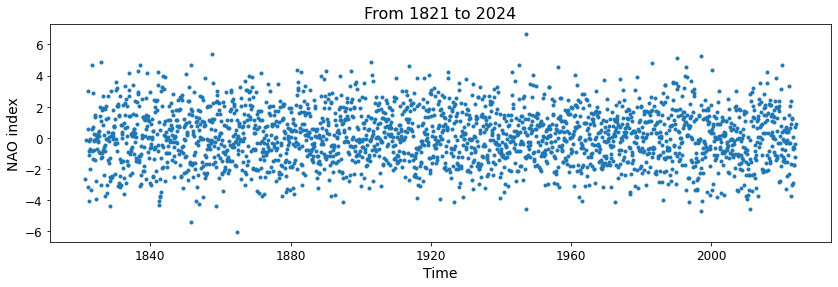

In [140]:
nao_monthly = df_nao_monthly.to_numpy().flatten()
month_nao = np.arange(len(nao_monthly))

# Create a datetime64 array for the NAO.
years_nao_array = (df_nao.year[0] + np.floor(month_nao/12)).astype('int')
months_nao_array = (month_nao%12).astype('int')+1
time_nao = np.zeros_like(nao_monthly,dtype='datetime64[s]')

for kk in range(len(nao_monthly)):
    time_nao[kk] = np.datetime64(str(years_nao_array[kk])+'-'+str(months_nao_array[kk]).zfill(2))

# Plot the NAO time series.
plt.figure(figsize=(14,4))
plt.plot(time_nao, nao_monthly,'.')
plt.ylabel('NAO index',fontsize=14)
plt.xlabel('Time',fontsize=14)
plt.title('From '+ str(df_nao.year[0]) + ' to '+ str(df_nao.year.to_numpy()[-1]),fontsize=16)
plt.tick_params(axis='both', labelsize=12)

plt.savefig('./figures/'+'nao_monthly_timeseries.png',bbox_inches = 'tight')

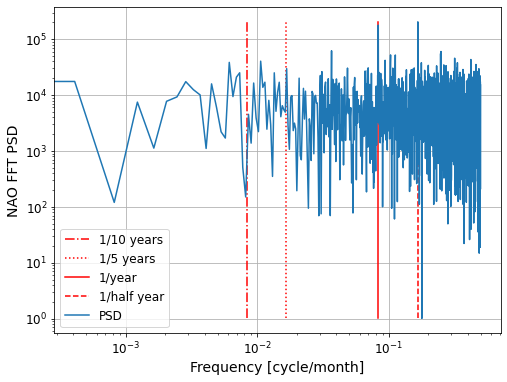

In [347]:
# Now do the FFT on the NAO monthly time series.

nao4fft = nao_monthly
nao4fft[np.isnan(nao4fft)] = 0 # Replace nan with 0.

hat = fft(np.array(nao4fft))
freq = fftfreq(len(nao4fft)) # Cycles/month

plt.figure(figsize=(8,6))
psd = np.abs(hat)**2
a = np.min(psd)
b = np.max(psd)

plt.plot(1/120*np.array([1,1]),np.array([a,b]),'r-.')
plt.plot(1/60*np.array([1,1]),np.array([a,b]),'r:')
plt.plot(1/12*np.array([1,1]),np.array([a,b]),'r')
plt.plot(1/6*np.array([1,1]),np.array([a,b]),'r--')

N = len(psd)
plt.plot(freq[0:round(N/2)], psd[0:round(N/2)])

plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.ylabel('NAO FFT PSD',fontsize=14)
plt.xlabel('Frequency [cycle/month]',fontsize=14)
plt.legend(['1/10 years','1/5 years','1/year','1/half year','PSD'],fontsize=12)
plt.tick_params(axis='both', labelsize=12)

plt.savefig('./figures/'+'nao_monthly_psd.png',bbox_inches = 'tight')

In [141]:
# Separate the seasons in the NAO time series.
year_nao, nao_mam = get_nao_season('MAM')
year_nao, nao_jja = get_nao_season('JJA')
year_nao, nao_son = get_nao_season('SON')
year_nao, nao_djf = get_nao_season('DJF')

<ipython-input-49-98b5c8740a92>:25: RuntimeWarning: Mean of empty slice
  nao_season[yy] = np.nanmean(nao_season_months[yy*3:yy*3+3])
<ipython-input-49-98b5c8740a92>:21: RuntimeWarning: Mean of empty slice
  nao_season[yy] = np.nanmean(nao_season_months[0:2])
<ipython-input-49-98b5c8740a92>:23: RuntimeWarning: Mean of empty slice
  nao_season[yy] = np.nanmean(nao_season_months[yy*3-1:yy*3+2])


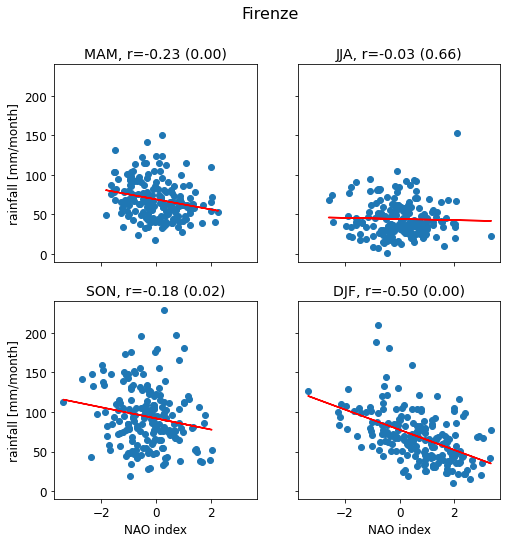

In [142]:
# Compute the correlation coefficient between seasonal NAO and rainfall.

# Slice the NAO time series only in the years where we have valid rainfall data.
# NAO time series are longer than rainfall ones.
y0 = yor_u[0]
y1 = yor_u[-1]
x = np.zeros((len(yor_u),4))
y = np.zeros((len(yor_u),4))

sl_list = ['MAM','JJA','SON','DJF']

nao_mam_select = nao_mam[(year_nao>=y0)&(year_nao<=y1)]
nao_jja_select = nao_jja[(year_nao>=y0)&(year_nao<=y1)]
nao_son_select = nao_son[(year_nao>=y0)&(year_nao<=y1)]
nao_djf_select = nao_djf[(year_nao>=y0)&(year_nao<=y1)]

nao_xx = np.stack([nao_mam_select,nao_jja_select,nao_son_select,nao_djf_select]) # nao_xx[0,:] is nao_mam_select
rain_yy = np.stack([rainfall_mam,rainfall_jja,rainfall_son,rainfall_djf])

fig, axs = plt.subplots(2,2,sharex=True,sharey=True,figsize=(8,8))
axs = axs.ravel()

for jj in range(4):
    nao_x = nao_xx[jj,:]
    rain_y = rain_yy[jj,:]
    x, y = nao_x[(~np.isnan(nao_x))&(~np.isnan(rain_y))], rain_y[(~np.isnan(nao_x))&(~np.isnan(rain_y))]
    axs[jj].scatter(x,y)
    axs[jj].tick_params(axis='both',labelsize=12)
    if jj>1:
        axs[jj].set_xlabel('NAO index',fontsize=12)
    if jj==0 or jj==2:
        axs[jj].set_ylabel('rainfall [mm/month]',fontsize=12)
        
    slope,intercept,rvalue,pvalue,stderr=linregress(x,y)
    axs[jj].plot(x,slope*x+intercept,'r')
    
    axs[jj].set_title(f'{sl_list[jj]}, r={rvalue:.2f} ({pvalue:.2f})',fontsize=14)

plt.suptitle(title_str,fontsize=16)
plt.savefig('./figures/'+case_study+'nao_rainfall_seasonal_correlation.png',bbox_inches = 'tight')

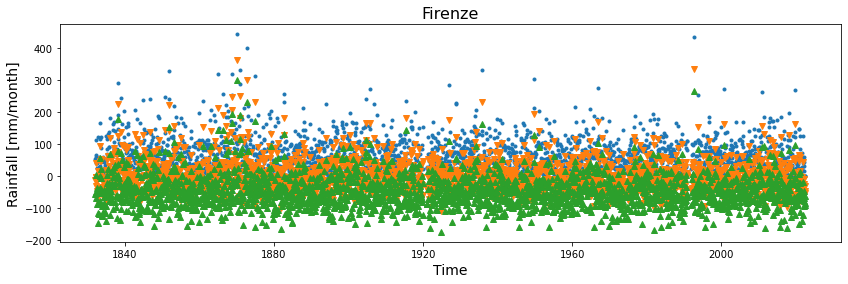

In [149]:
# Now I can compute the seasonal residuals (by removing the seasonal cycle at the monthly time scale) for all 
# stations.
# We could then compute the spatial correlation between those, to see whether the residuals are spatially
# correlated and, thus, they correspond to large or local systems.
# The pdf of the residuals could also be informative in terms of intensity of the events.

# Remove the seasonal cycle, considering that the first month of the record is always Jan.

rainfall_no_ss = np.zeros(len(rainfall_regular))
rainfall_no_ss_1std = np.zeros(len(rainfall_regular))
for ll in range(len(rainfall_regular)):
    moy = ll%12+1 # month of the year
    rainfall_no_ss[ll] = rainfall_regular[ll] - seasonal_cycle_mean[moy-1]
    rainfall_no_ss_1std[ll] = rainfall_regular[ll] - seasonal_cycle_mean[moy-1] - seasonal_cycle_std[moy-1]

plt.figure(figsize=(14,4))

plt.plot(time_regular,rainfall_regular,'.')
plt.ylabel('Rainfall [mm/month]',fontsize=14)
plt.xlabel('Time',fontsize=14)
plt.title(title_str,fontsize=16)

plt.plot(time_regular,rainfall_no_ss,'v')
plt.plot(time_regular,rainfall_no_ss_1std,'^')

# Save the regular rainfall and the time series with no seasonal cycle.
d = {'time_regular':np.transpose(time_regular), 
     'rainfall_regular':np.transpose(rainfall_regular), 
     'rainfall_no_ss':np.transpose(rainfall_no_ss),
     'rainfall_no_ss_1std':np.transpose(rainfall_no_ss_1std)}
df = pd.DataFrame(data=d)
df.to_csv('./'+case_study+'_regular_rainfall.txt', index=False)

<ipython-input-48-f0ef4fb63114>:32: RuntimeWarning: Mean of empty slice
  rainfall_season[yy] = np.nanmean(rainfall_regular[ma:mb])
<ipython-input-48-f0ef4fb63114>:32: RuntimeWarning: Mean of empty slice
  rainfall_season[yy] = np.nanmean(rainfall_regular[ma:mb])
<ipython-input-48-f0ef4fb63114>:32: RuntimeWarning: Mean of empty slice
  rainfall_season[yy] = np.nanmean(rainfall_regular[ma:mb])
<ipython-input-48-f0ef4fb63114>:32: RuntimeWarning: Mean of empty slice
  rainfall_season[yy] = np.nanmean(rainfall_regular[ma:mb])
<ipython-input-48-f0ef4fb63114>:32: RuntimeWarning: Mean of empty slice
  rainfall_season[yy] = np.nanmean(rainfall_regular[ma:mb])


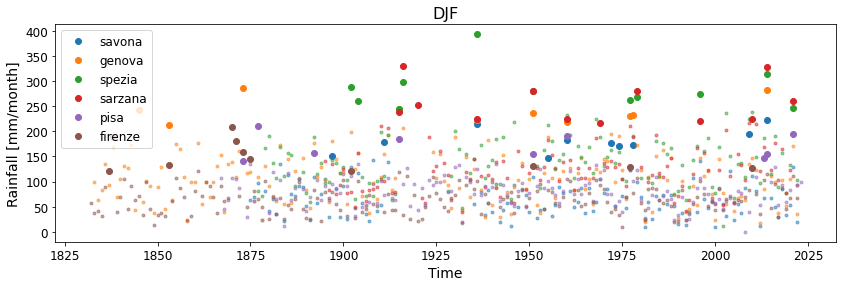

In [157]:
# Now take all the stations together and compare them at the seasonal scale.

case_list = ['savona','genova','spezia','sarzana','pisa','firenze']
label_season = 'DJF'

plt.figure(figsize=(14,4))
cc = 0

for case in case_list:
    df = pd.read_csv('./'+case+'_regular_rainfall.txt') 
    time_regular = df.time_regular.values.astype('datetime64[D]')
    rainfall_regular = df.rainfall_regular.values
    rainfall_no_ss = df.rainfall_no_ss.values
    rainfall_no_ss_1std = df.rainfall_no_ss_1std.values
    
    offset_y = time_regular[0].astype('datetime64[Y]').astype(int) + 1970
    yor_u, rainfall_season = get_rainfall_season(rainfall_regular,label_season,offset_y)
    yor_u_ss, rainfall_season_no_ss_season = get_rainfall_season(rainfall_no_ss,label_season,offset_y)
    yor_u_ss_1tsd, rainfall_season_no_ss_1std_season = get_rainfall_season(rainfall_no_ss_1std,label_season,offset_y)
    
    #plt.plot(time_regular,rainfall_regular,'.',label=case)
    plt.plot(yor_u,rainfall_season,'.',color='C'+str(cc),alpha=0.5)
    plt.plot(yor_u[rainfall_season_no_ss_1std_season>0],rainfall_season[rainfall_season_no_ss_1std_season>0],
             'o',color='C'+str(cc),label=case)
    cc += 1
    
plt.legend(fontsize=12)
plt.ylabel('Rainfall [mm/month]',fontsize=14)
plt.xlabel('Time',fontsize=14)
plt.title(label_season,fontsize=16)
plt.tick_params(axis='both', labelsize=12)

plt.savefig('./figures/heavy_rainfall_'+label_season+'.png',bbox_inches = 'tight')

[54.6        59.6        64.9        ...  1.40000005  2.00000003
  1.39999998]
0.9795131955093701 -9.99535802340479e-27 2.035922882645699


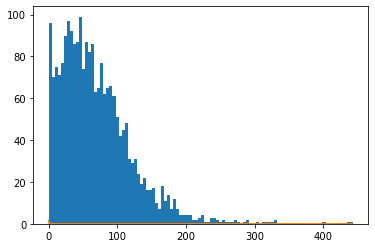

In [268]:
# Look at the distribution of rainfall and fit a gamma function to it.
data = rainfall_regular[rainfall_regular>=0]

import scipy.stats as stats    
fit_alpha, fit_loc, fit_beta=stats.gamma.fit(data)
print(fit_alpha,fit_loc,fit_beta)

ics = np.arange(np.min(data),np.max(data))
#ipsilon = stats.gamma.pdf((ics-fit_loc)/fit_beta, fit_alpha)/fit_beta
ipsilon = stats.gamma.pdf(ics, fit_alpha, fit_loc, fit_beta)

plt.hist(data,bins=100)
plt.plot(ics,ipsilon,'-')


#plt.hist(np.log(rainfall_regular[rainfall_regular>0]),bins=50)

<ipython-input-163-71b40b59fbaa>:29: RuntimeWarning: divide by zero encountered in true_divide
  rainfall_nan = 1/rainfall_nan


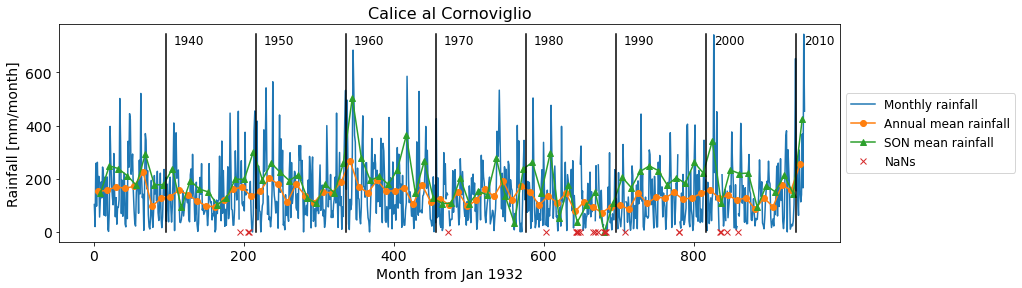

In [163]:
# From here the script works with data contained in './data/v1/'

case_study = 'santamargherita'; title_str = 'Santa Margherita'
case_study = 'vareseligure'; title_str = 'Varese Ligure'
case_study = 'calice'; title_str = 'Calice al Cornoviglio'
#case_study = 'lafoce'; title_str = 'La Foce'

filename = case_study + '.txt'
df = pd.read_csv(path2data+filename,delimiter='\t')

month_from_beg = np.arange(1,len(df.rainfall)+1) # count the number of months from the beginning.
rainfall_with_nan = df.rainfall
rainfall = np.nan_to_num(df.rainfall,nan=0)

plt.figure(figsize=(14,4))
plt.plot(month_from_beg, rainfall_with_nan)
plt.ylabel('Rainfall [mm/month]',fontsize=14)
plt.xlabel('Month from ' + str(df.month[0]) +' '+ str(df.year[0]),fontsize=14)
plt.title(title_str,fontsize=16)

year_from_beg = np.arange(1,round(len(rainfall_with_nan)/12)+1)
scale = 1 + 12*(year_from_beg-1)
#plt.plot(scale,np.zeros(len(scale)),'.') # Every Jan has a small dot on the time axis.

# Plot the annual rainfall and the SON rainfall.
annual_rainfall = np.zeros(len(year_from_beg))
son_rainfall = np.zeros(len(year_from_beg))

for k in range(len(year_from_beg)):
    annual_rainfall[k] = np.nansum(rainfall_with_nan[12*k:12*(k+1)])
    son_rainfall[k] = np.nansum(rainfall_with_nan[8+k*12:11+k*12])
    
plt.plot(scale+5,annual_rainfall/12,'o-') # Plot the mean annual rainfall
plt.plot(scale+8,son_rainfall/3,'^-') # Plot the mean annual rainfall
    
# Check if there are NaNs and replace them with 0.
rainfall_nan = np.zeros(len(df.rainfall))
rainfall_nan[np.isnan(df.rainfall)] = 1
rainfall_nan = 1/rainfall_nan
plt.plot(month_from_beg,rainfall_nan,'x')

plt.tick_params(axis='both', labelsize=14)

plt.legend(['Monthly rainfall', 'Annual mean rainfall', 'SON mean rainfall', 'NaNs'], fontsize=12,
          loc='center left', bbox_to_anchor=(1, 0.5))

# Plot some vertical lines with the decades.
extreme = np.max(rainfall)
y0 = df.year[0] # First year of the record.
if (case_study=='calice') or (case_study=='lafoce'):
    last_decade = 2020
else:
    last_decade = 2030
for yy in np.arange(1940,last_decade,10):
    offset = yy-y0
    plt.plot((scale[offset],scale[offset]),(0, extreme),'k')
    plt.text(scale[offset]+10, 0.95*extreme, str(yy), fontsize=12)
#    print(scale[offset])

plt.savefig(case_study + '_monthly_timeseries.png',bbox_inches = 'tight')

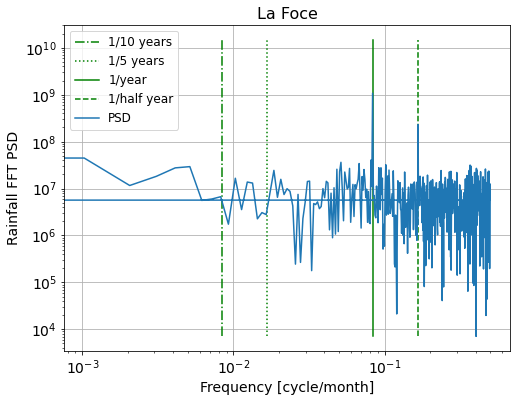

In [154]:
# Look at the FFT of the monthly data.
hat = fft(np.array(rainfall))
freq = fftfreq(len(rainfall)) # Cycles/month

plt.figure(figsize=(8,6))
psd = np.abs(hat)**2
a = np.min(psd)
b = np.max(psd)

plt.plot(1/120*np.array([1,1]),np.array([a,b]),'g-.')
plt.plot(1/60*np.array([1,1]),np.array([a,b]),'g:')
plt.plot(1/12*np.array([1,1]),np.array([a,b]),'g')
plt.plot(1/6*np.array([1,1]),np.array([a,b]),'g--')

plt.plot(freq, psd)

plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.ylabel('Rainfall FFT PSD',fontsize=14)
plt.xlabel('Frequency [cycle/month]',fontsize=14)
plt.legend(['1/10 years','1/5 years','1/year','1/half year','PSD'],fontsize=12)
plt.title(title_str,fontsize=16)
plt.tick_params(axis='both', labelsize=14)

plt.savefig(case_study + '_monthly_psd.png',bbox_inches = 'tight')

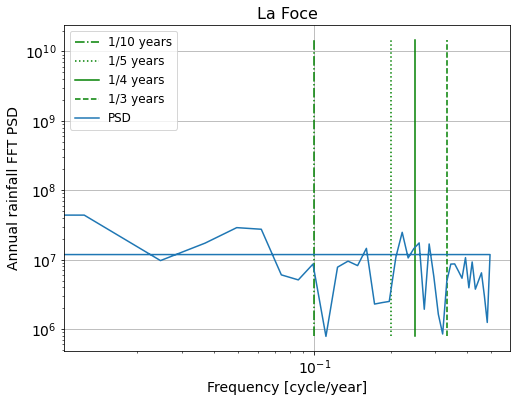

In [155]:
# Look at the FFT of the annual data.
hat = fft(np.array(annual_rainfall))
freq = fftfreq(len(annual_rainfall)) # Cycles/year

plt.figure(figsize=(8,6))
psd = np.abs(hat)**2
a = np.min(psd)
b = np.max(psd)

plt.plot(1/10*np.array([1,1]),np.array([a,b]),'g-.')
plt.plot(1/5*np.array([1,1]),np.array([a,b]),'g:')
plt.plot(1/4*np.array([1,1]),np.array([a,b]),'g')
plt.plot(1/3*np.array([1,1]),np.array([a,b]),'g--')

plt.plot(freq, psd)

plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.ylabel('Annual rainfall FFT PSD',fontsize=14)
plt.xlabel('Frequency [cycle/year]',fontsize=14)
plt.legend(['1/10 years','1/5 years','1/4 years','1/3 years','PSD'],fontsize=12)
plt.title(title_str,fontsize=16)
plt.tick_params(axis='both', labelsize=14)

plt.savefig(case_study + '_annual_psd.png',bbox_inches = 'tight')

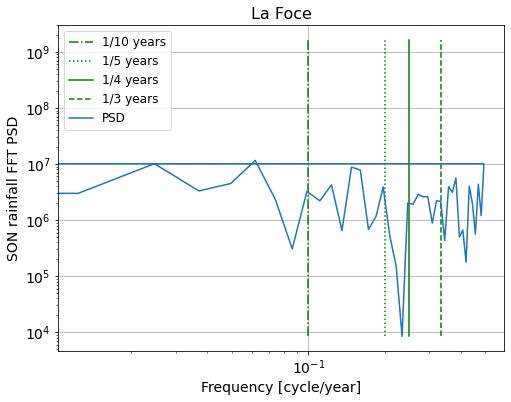

In [156]:
# Look at the FFT of the SON rainfall with annual step.
hat = fft(np.array(son_rainfall))
freq = fftfreq(len(son_rainfall)) # Cycles/year

plt.figure(figsize=(8,6))
psd = np.abs(hat)**2
a = np.min(psd)
b = np.max(psd)

plt.plot(1/10*np.array([1,1]),np.array([a,b]),'g-.')
plt.plot(1/5*np.array([1,1]),np.array([a,b]),'g:')
plt.plot(1/4*np.array([1,1]),np.array([a,b]),'g')
plt.plot(1/3*np.array([1,1]),np.array([a,b]),'g--')

plt.plot(freq, psd)

plt.yscale('log')
plt.xscale('log')
plt.grid()
plt.ylabel('SON rainfall FFT PSD',fontsize=14)
plt.xlabel('Frequency [cycle/year]',fontsize=14)
plt.legend(['1/10 years','1/5 years','1/4 years','1/3 years','PSD'],fontsize=12)
plt.title(title_str,fontsize=16)
plt.tick_params(axis='both', labelsize=14)

plt.savefig(case_study + '_son_psd.png',bbox_inches = 'tight')

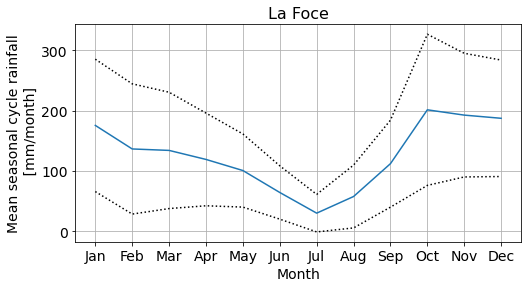

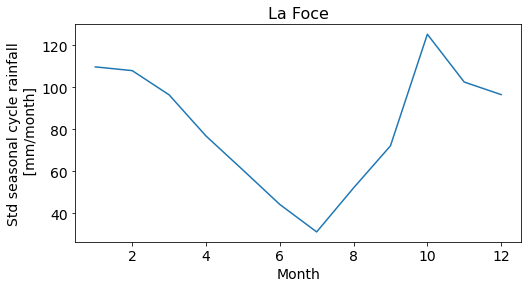

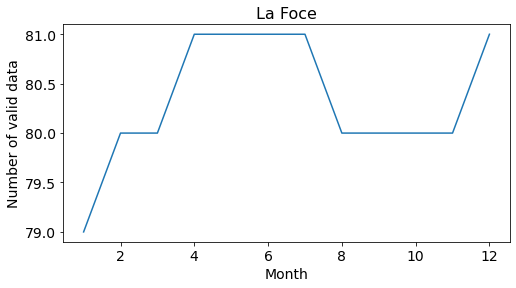

In [157]:
# Calculate the seasonal cycle. It is assumed that the first month of the record is Jan.

rainfall_year_rows = np.zeros((len(year_from_beg),12))

for k in range(len(year_from_beg)):
    rainfall_year_rows[k,:] = rainfall_with_nan[12*k:12*(k+1)]
    
seasonal_cycle_mean = np.nanmean(rainfall_year_rows,axis=0)
seasonal_cycle_std = np.nanstd(rainfall_year_rows,axis=0)
seasonal_cycle_num = np.sum(np.double(~np.isnan(rainfall_year_rows)),axis=0)

plt.figure(figsize=(8,4))
plt.plot(np.arange(12), seasonal_cycle_mean)
plt.plot(np.arange(12), seasonal_cycle_mean-seasonal_cycle_std,':k')
plt.plot(np.arange(12), seasonal_cycle_mean+seasonal_cycle_std,':k')
plt.ylabel('Mean seasonal cycle rainfall\n [mm/month]',fontsize=14)
plt.xlabel('Month',fontsize=14)
plt.title(title_str,fontsize=16)
plt.xticks(ticks=np.arange(12),labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.tick_params(axis='both', labelsize=14)
plt.grid()
plt.savefig(case_study + '_seasonal_cycle.png',bbox_inches = 'tight')
plt.show()

plt.figure(figsize=(8,4))
plt.plot(np.arange(1,13), seasonal_cycle_std)
plt.ylabel('Std seasonal cycle rainfall\n [mm/month]',fontsize=14)
plt.xlabel('Month',fontsize=14)
plt.title(title_str,fontsize=16)
plt.tick_params(axis='both', labelsize=14)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(np.arange(1,13), seasonal_cycle_num)
plt.ylabel('Number of valid data',fontsize=14)
plt.xlabel('Month',fontsize=14)
plt.title(title_str,fontsize=16)
plt.tick_params(axis='both', labelsize=14)
plt.show()

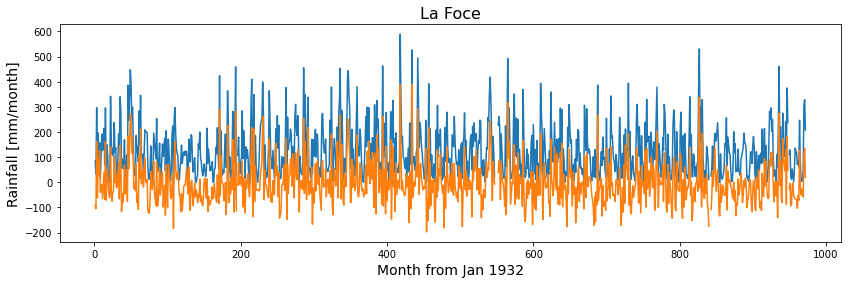

In [158]:
# Remove the seasonal cycle and do the Fourier analysis. The first month of the record is supposed to be Jan.

rainfall_no_ss = np.zeros(len(rainfall_with_nan))
for ll in range(len(rainfall_with_nan)):
    moy = ll%12 # month of the year
    rainfall_no_ss[ll] = rainfall_with_nan[ll] - seasonal_cycle_mean[moy]

plt.figure(figsize=(14,4))

plt.plot(month_from_beg, df.rainfall)
plt.ylabel('Rainfall [mm/month]',fontsize=14)
plt.xlabel('Month from ' + str(df.month[0]) +' '+ str(df.year[0]),fontsize=14)
plt.title(title_str,fontsize=16)

plt.plot(month_from_beg,rainfall_no_ss)

<ipython-input-159-e6fa90801816>:5: RuntimeWarning: Mean of empty slice
  son_rainfall[yl]=np.nanmean(rainfall_with_nan[8+yl*12:11+yl*12])
<ipython-input-159-e6fa90801816>:6: RuntimeWarning: Mean of empty slice
  son_rainfall_no_ss[yl]=np.nanmean(rainfall_no_ss[8+yl*12:11+yl*12])


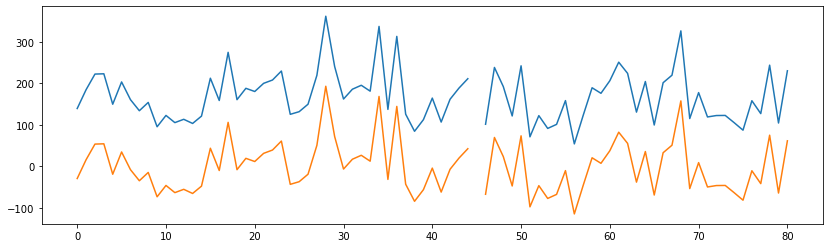

In [159]:
# Take the SON rainfall (with and without the seasonal cycle).
son_rainfall = np.zeros(len(year_from_beg))
son_rainfall_no_ss = np.zeros(len(year_from_beg))
for yl in range(len(year_from_beg)):
    son_rainfall[yl]=np.nanmean(rainfall_with_nan[8+yl*12:11+yl*12])
    son_rainfall_no_ss[yl]=np.nanmean(rainfall_no_ss[8+yl*12:11+yl*12])    

plt.figure(figsize=(14,4))
plt.plot(son_rainfall)
plt.plot(son_rainfall_no_ss)